In [22]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

In [23]:
# Simulation parameters
TimeSplit = "2025-01-01"
starting_cash = 1000

In [24]:
# --- Carica dati e modello ---
model_name = "rf"

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

models = {}

for tiker in stocks:
    df = pd.read_csv(
        f"csv/{tiker}_indicators.csv",
        index_col=0,
        parse_dates=[0],
        date_format="ISO8601"
    )

    bundle = joblib.load(f"models/{model_name}_{tiker}_v1.joblib")
    model = bundle["model"]
    features = bundle["features"]

    models[f"{tiker}"] = {
        "model": model,
        "features": features,
        "test_data": df[df.index >= TimeSplit]
    }
    

==========AAPL==========
Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 1058.109422003217 | Guadagno 5.811 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 1086.0354954028542 | Guadagno 8.604 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 931.7856044079879 | Guadagno -6.821 %


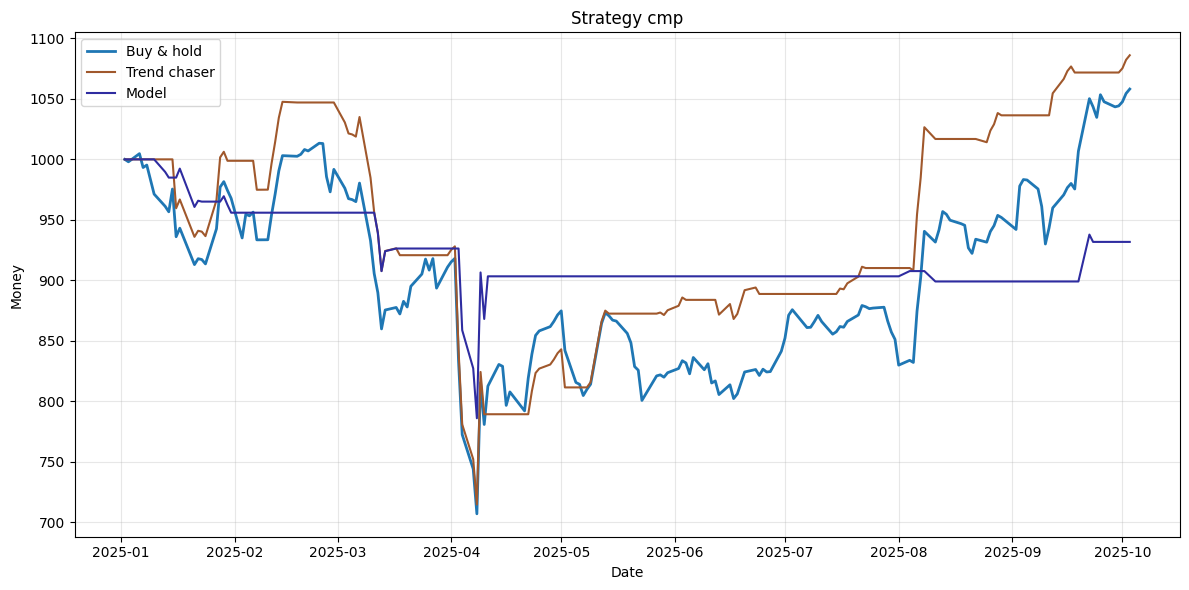

==========META==========
Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 1185.7686555276111 | Guadagno 18.577 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 916.8863402773225 | Guadagno -8.311 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 1103.5101750863978 | Guadagno 10.351 %


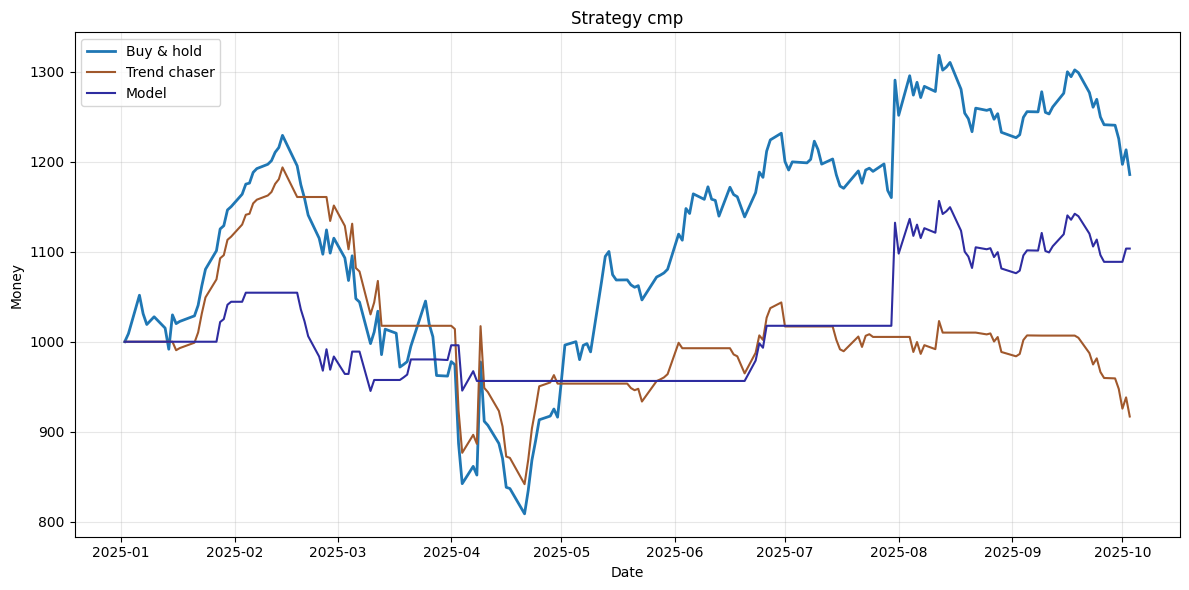

==========ORCL==========
Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 1723.4235785835456 | Guadagno 72.342 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 1422.7985353899155 | Guadagno 42.280 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 1437.9272419601095 | Guadagno 43.793 %


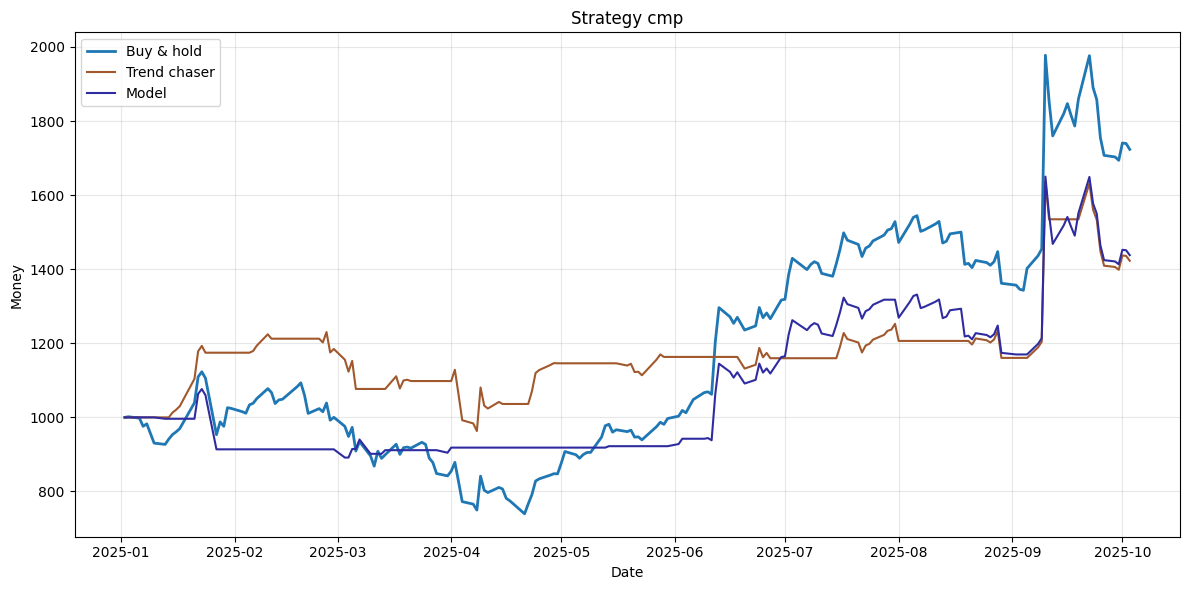

==========MSFT==========
Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 1235.9644325628067 | Guadagno 23.596 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 1042.3956493685828 | Guadagno 4.240 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 1124.6186696439972 | Guadagno 12.462 %


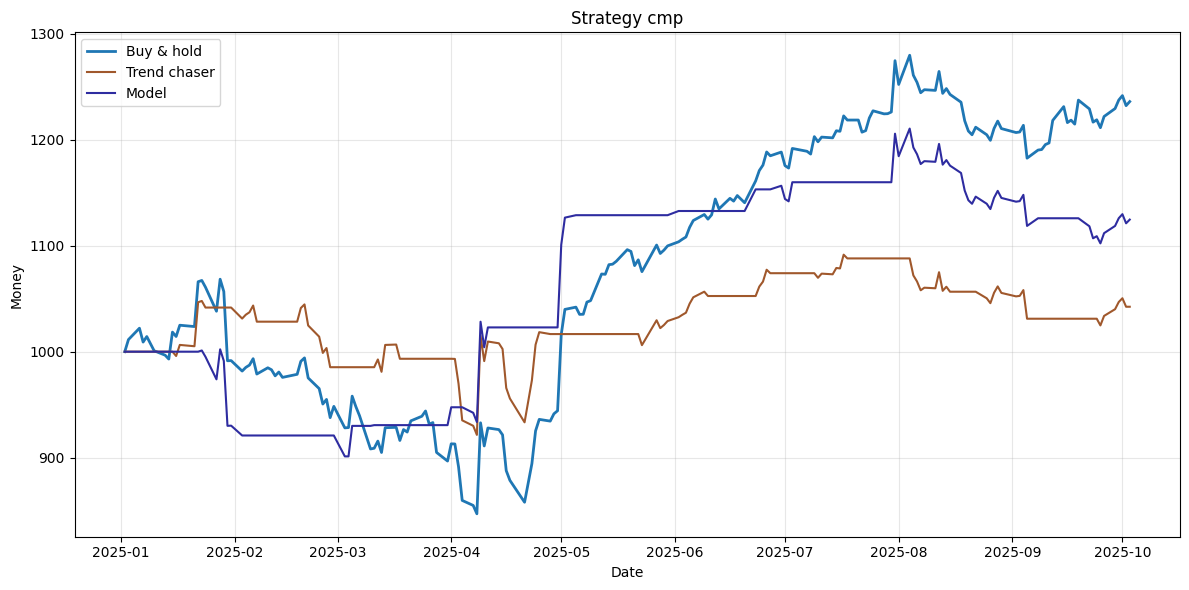

In [28]:
for tiker, data in models.items():
    print("=" * 10 + f"{tiker}" + "=" * 10)

    # Baseline trading stategy: buy and hold
    number_of_actions = starting_cash / data["test_data"].iloc[0]["Close"]
    payout_bnh = number_of_actions * data["test_data"].iloc[-1]["Close"]

    # Second baseline: trend chaser (apply-based)
    trand_chaser = {
        "cash": starting_cash,
        "shares": 0.0,
        "prev_price": None,
        "streak": 0,
        "trashold": 3,
        "data": data["test_data"].copy()
    }

    def step(row):
        price = float(row["Close"])
        prev = trand_chaser["prev_price"]

        # initialize on first row
        if prev is None:
            trand_chaser["prev_price"] = price
            portfolio = trand_chaser["cash"] + trand_chaser["shares"] * price
            return portfolio

        # replicate the original decision logic
        if trand_chaser["shares"] <= 0:
            # bear
            if prev > price:
                trand_chaser["streak"] += 1
            else:
                if trand_chaser["streak"] >= trand_chaser["trashold"]:
                    # original code added more shares using all cash
                    trand_chaser["shares"] += trand_chaser["cash"] / price
                    trand_chaser["cash"] = 0.0
                    trand_chaser["streak"] = 0
        else:
            # Bull
            if prev <= price:
                trand_chaser["streak"] += 1
            else:
                if trand_chaser["streak"] >= trand_chaser["trashold"]:
                    # original code sold shares (though shares==0 here in original), keep same behaviour
                    trand_chaser["cash"] += trand_chaser["shares"] * price
                    trand_chaser["shares"] = 0.0
                    trand_chaser["streak"] = 0

        trand_chaser["prev_price"] = price
        portfolio = trand_chaser["cash"] + trand_chaser["shares"] * price

        # Debug print
        #print(f"data : {row.name.strftime("%Y-%m-%d")} | shares : {state['shares']} | cash: {state['cash']} | price : {("Bear" if (state["prev_price"] > price) else "Bull")} | {state["streak"]}")

        return portfolio
    
    trand_chaser["data"].loc[:, "portfolio_value"] = trand_chaser["data"].apply(step, axis=1)
    payout_tc = trand_chaser["cash"] + (trand_chaser["shares"] * trand_chaser["data"].iloc[-1]["Close"])

    # Model
    state_modello = {
        "cash": starting_cash,
        "shares": 0.0,
        "data": data["test_data"].copy()
    }

    # Predict the data
    state_modello["data"].loc[:, "model_action"] = data["model"].predict(state_modello["data"][data["features"]])

    def model_action(row):
        price = float(row["Close"])
        action = row["model_action"]


        if action == 'BUY':
            if state_modello["cash"] > 0:
                state_modello["shares"] = state_modello["cash"] / price 
                state_modello["cash"] = 0
        elif action == 'SELL':
            if state_modello["shares"] > 0:
                state_modello["cash"] = state_modello["shares"] * price
                state_modello["shares"] = 0.0

        #print(f" date: {row.name.strftime("%Y-%m-%d")} | signal : {action} | cash: {state["cash"]} | shares: {state["shares"]}")
        return state_modello["cash"] + state_modello["shares"] * price

    # assign results explicitly with .loc
    state_modello["data"].loc[:, "model_value"] = state_modello["data"].apply(model_action, axis=1)

    # final payout following the same formula used previously
    payout_mod = state_modello["cash"] + (state_modello["shares"] * state_modello["data"].iloc[-1]["Close"])
    

    print(f"Baseline 1: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_bnh} | Guadagno {((payout_bnh - starting_cash)/starting_cash) * 100:.3f} %")
    print(f"Baseline 2: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_tc} | Guadagno {((payout_tc - starting_cash)/starting_cash) * 100:.3f} %")
    print(f"Modello: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_mod} | Guadagno {((payout_mod - starting_cash)/starting_cash) * 100:.3f} %")
    
    plt.figure(figsize=(12,6))
    plt.plot(data["test_data"].index, (data["test_data"]["Close"] *  number_of_actions), label='Buy & hold', color='#1f77b4', linewidth=2)
    plt.plot(data["test_data"].index, trand_chaser["data"]["portfolio_value"], label='Trend chaser', color="#a0582c")
    plt.plot(data["test_data"].index, state_modello["data"]["model_value"], label='Model', color="#2e2ca0")
    plt.title("Strategy cmp")
    plt.xlabel("Date")
    plt.ylabel("Money")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [26]:
# Second baseline: trend chaser (apply-based)
state = {
    "cash": starting_cash,
    "shares": 0.0,
    "prev_price": None,
    "streak": 0,
    "trashold": 3
}

def step(row):
    price = float(row["Close"])
    prev = state["prev_price"]

    # initialize on first row
    if prev is None:
        state["prev_price"] = price
        portfolio = state["cash"] + state["shares"] * price
        return portfolio

    # replicate the original decision logic
    if state["shares"] <= 0:
        # bear
        if prev > price:
            state["streak"] += 1
        else:
            if state["streak"] >= state["trashold"]:
                # original code added more shares using all cash
                state["shares"] += state["cash"] / price
                state["cash"] = 0.0
                state["streak"] = 0
    else:
        # Bull
        if prev <= price:
            state["streak"] += 1
        else:
            if state["streak"] >= state["trashold"]:
                # original code sold shares (though shares==0 here in original), keep same behaviour
                state["cash"] += state["shares"] * price
                state["shares"] = 0.0
                state["streak"] = 0

    state["prev_price"] = price
    portfolio = state["cash"] + state["shares"] * price

    # Debug print
    #print(f"data : {row.name.strftime("%Y-%m-%d")} | shares : {state['shares']} | cash: {state['cash']} | price : {("Bear" if (state["prev_price"] > price) else "Bull")} | {state["streak"]}")

    return portfolio

# apply the function row-wise; apply executes in index order
testdata.loc[:, "portfolio_value"] = testdata.apply(step, axis=1)

# final payout following the same formula used previously
payout = state["cash"] + (state["shares"] * testdata.iloc[-1]["Close"])

print(f"Soldi di partenza: {starting_cash} | Soldi alla fine {payout} | Guadagno {((payout - starting_cash)/starting_cash) * 100:.3f} %")


plt.figure(figsize=(12,6))
#plt.plot(testdata.index, testdata["portfolio_value"], label='Portfolio value (trend chaser)', color='#2ca02c')
plt.plot(testdata.index, testdata["portfolio_value"], label='Close price', color="#a0582c")
plt.title('Trend chaser')
plt.xlabel('Date')
plt.ylabel('Money')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'testdata' is not defined

Soldi di partenza: 1000 | Soldi alla fine 1229.1237581505561 | Guadagno 22.912 %


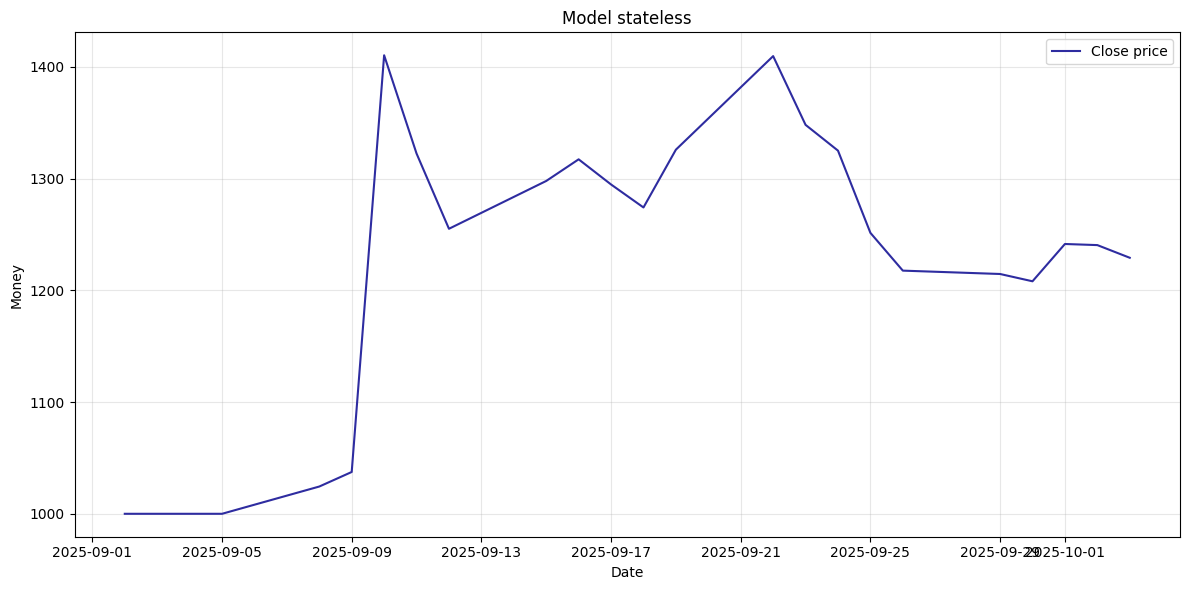

In [ ]:
# Statless model action
Y = rf.predict(testdata[features])

# assign into testdata explicitly using .loc to avoid SettingWithCopyWarning
testdata.loc[:, "model_action"] = Y

state = {
    "cash": starting_cash,
    "shares": 0.0
}

def model_action(row):
    price = float(row["Close"])
    action = row["model_action"]


    if action == 'BUY':
        if state["cash"] > 0:
            state["shares"] = state["cash"] / price 
            state["cash"] = 0
    elif action == 'SELL':
        if state["shares"] > 0:
            state["cash"] = state["shares"] * price
            state["shares"] = 0.0

    #print(f" date: {row.name.strftime("%Y-%m-%d")} | signal : {action} | cash: {state["cash"]} | shares: {state["shares"]}")
    return state["cash"] + state["shares"] * price

# assign results explicitly with .loc
testdata.loc[:, "model_value"] = testdata.apply(model_action, axis=1)

# final payout following the same formula used previously
payout = state["cash"] + (state["shares"] * testdata.iloc[-1]["Close"])

print(f"Soldi di partenza: {starting_cash} | Soldi alla fine {payout} | Guadagno {((payout - starting_cash)/starting_cash) * 100:.3f} %")


plt.figure(figsize=(12,6))
plt.plot(testdata.index, testdata["model_value"], label='Close price', color="#2e2ca0")
plt.title('Model stateless')
plt.xlabel('Date')
plt.ylabel('Money')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

|Ticker|Baseline 1|Baseline 2| Model|
|---|---|---|---|
|AAPL|12.319%|4.789%|**3.637%**|
|META|-3.340%|0.680%|**-3.156%**|
|MSFT|2.421%|-0.423%|**0.534%**|
|ORCL|27.004%|2.838%|**22.913%**|